# STEP 1 -잡음제거

최초 30억개의 데이터 중에서 ID, Domain, PW가 모두 일치하는 완전한 identical한 ID를 제거하니

약 15억개로 데이터 숫자가 감소하였다.

이후 1.Noise_Clean.ipynb 파일을 통해 a~z, A~Z, 0~9 파일을 순차적으로 로드한 후

available character가 아닌 문자 (ex- î¶õ ) 가 포함된 데이터를 모두 제거한뒤 1,376,342,362 개의

(약 13.7억) 데이터를 확보하였다.


# STEP2 -연관성있는 데이터 Filtering(LSH)

LSH/LSH_a~z.ipynb 는 a와A, b와B, c와C, ~ , z와Z, 0~9를 합친 파일을 로드하여 유사한 데이터 끼리 묶는 역할을 한다.

최초 파일을 업로드 하고 reset index를 한다.
이후 5,000,000개 단위로 데이터를 나누고 Minhash함수를 이용해 forest를 계산하여 pickle로 오브젝트를 저장한다.
(저장경로 - ./LSH_Pickle/)

5,000,000개 단위로 test 변수에 임시저장 한다.

test는 dataframe 타입으로 'ID', 'Domain', 'PW'의 3개의 칼럼으로 구성되어있다. 

여기에 index 칼럼을 추가한다. 목적은 lsh함수에 idx를 넘겨주기 위함이다.

lsh함수는 idx를 전달받아. 해당 idx의 'ID'를 검색하고 이와 유사한 ID 30개를 Minhash 검색을 통해 찾는다.
이후 전달 받은 30개의 idx에 대응하는 PW를 찾고, 최초 idx에 해당하는 PW와 유사도를 jaro_winkler_distance를 
계산하여 높은 유사도를 가지는 데이터를 PWset 칼럼을 신설하고 값을 집어 넣는다. 

이후 중복제거를 위해 PWset의 리스트를 Hashing함수에 전달한다. 결과값으로 리스트 인자를 합을 hashing한 결과를 전달받아 HashTag 칼럼에 값을 넣는다.

이후 HashTag값을 기준으로 중복을 찾아 제거하면 중복제거를 할 수 있다.

최종 결과 데이터 프레임을 ./LSH_Data/ 경로에 pickle로 오브젝트를 저장한다.
총 0.96억 개(96,382,274)의 ID에 대해 3.09억 개(309,386,979)의 패스워드 데이터가 확보되었다. 최초 13억개의 데이터에서 대폭 감소했지만 사용자 ID에 대응되는 패스워드 이면서 서로 매우 높은 연관성(similarity)을 보이는 데이터들만 추출한 셈이다.


# STEP3 -데이터 타입별 분류(num,low,up,spc)

이번 단계에는 3.09억 개의 데이터를 총 15개의 타입으로 구분하는 작업을 수행한다. 
패스워드는 아래와 같이 num(숫자), low(소문자), up(대문자), spc(특수문자)의 4가지요소를 조합하여 15가지의 조합이 있을 수 있다.

Level1 = low, num, up, spc 

Level2 = low&num, up&low, up&num, spc&low, spc&num, spc&up 

Level3 = up&num&low, spc&num&low, spc&up&low, spc&up&num 

Level4 = all (low&num&up&spc) 



count_char_bit 는 임의이 패스워드 데이터가 입력되었을 때, low, up, num, spc중에 어떤 요소들이 있는지를 파악해서 출력해주는 함수이다. 결과는 low = 0001 , num = 0010, up = 0100, spc = 1000 등으로 이진수로 출력된다. 예를 들어, pass12는 소문자와 숫자를 포함하고 있다. 따라서 count_char_bit함수는 0011을 출력해서 low&num이라고 판단하게 된다. 

이렇게 low, up, num, spc부터 low&num&up 등 총 15개의 클래스로 패스워드를 분류할 수 있다. 


# STEP4 - 학습용 데이터 생성(src->tgt)

인공지능 모델을 이용해 효과적으로 학습하기 위해 패스워드 데이터 들을 복잡도에 따라 구분한다. 복잡도는 총 4개의 단계(lv.1 ~lv.4)로 구성되며 높은 단계의 패스워드는 좀 더 복잡한 구조를 가진다. 

앞 단계에서는 0.92억개의 ID에 대응되는 3.09억개의 데이터를 15개의 타입으로 분류하였다. 이번 단계에서는 최종적으로 인공지능 모델을 이용한 학습 및 추론에 알맞도록 데이터를 재구성한다. 우리가 사용할 seq2seq 자연어처리 모델은 번역, 챗봇, 내용 요약, STT(speach to text)등 다양한 분야에 활용된다. 본 연구에서 사용하는 seq2seq모델은 입력 시퀀스로 낮은 level의 데이터를 받아 출력시쿼드로 주어진 높은 level의 데이터를 모사하도록 학습한다. 학습이 완료된 후에 입력이 주어졌을 때 특정 형태의 패스워드 타입을 가지는 출력을 추론하도록 설계한다. 

위의 프로세스를 따라 src와 tgt로 데이터를 구분할 때 아래의 표와같이 총 64개의 case로 구성이 가능하다. 예를 들어, 입력으로 L(low- 소문자)가 주어졌을때 가능한 출력은 LN, LU, LS, LNU,LNS, LUS, LNUS 등 L을 반드시 포함하고 있다.

총 3.09억개의 데이터는 src와 tgt형태로 구성하면 총 1.4억 (144,244,123)쌍의 데이터를 얻는다. 
1.4억 쌍의 데이터는 (src n개, tgt n개)의 형태이다. 즉, src가 2개 이상 또는 tgt이 2개 이상, 또는 src/tgt 모두 2개 이상일 수 있다.

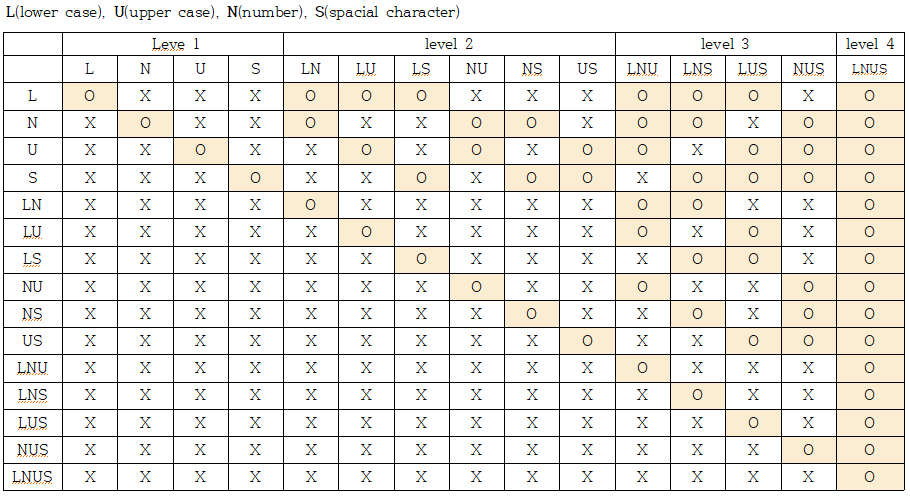

총 64개의 case에 우리가 가지고 있는 데이터의 분포를 표로 아래와 같이 나타낸다. 
소수점 아래 두째 자리에서 반올림하여 수치표시하였기 때문에 0이라고 표현되기도 한다.

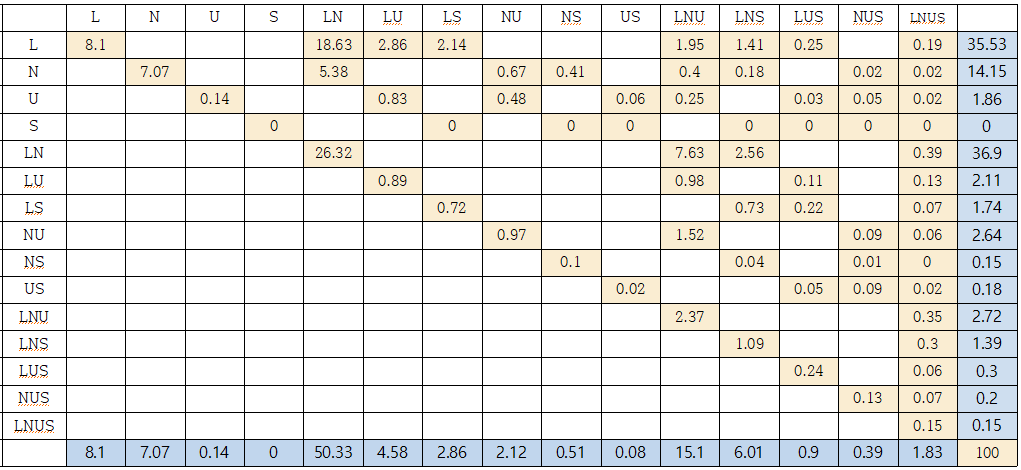

이중에서 1% 미만의 점유율이 낮은 데이터를 아래표와 같이 제거한다. 
총 100% 에서 94.68%로 감소한 것을 확인할 수 있다. 


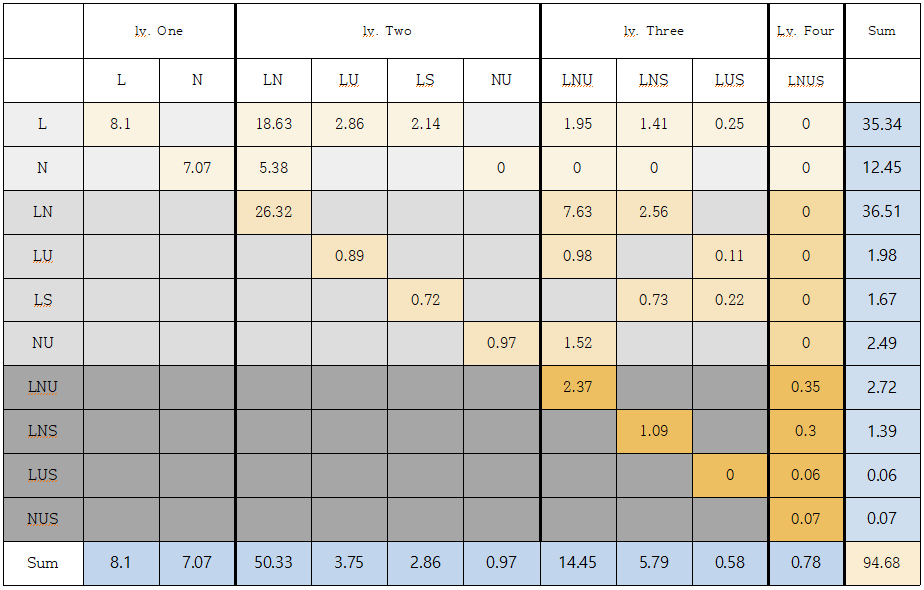

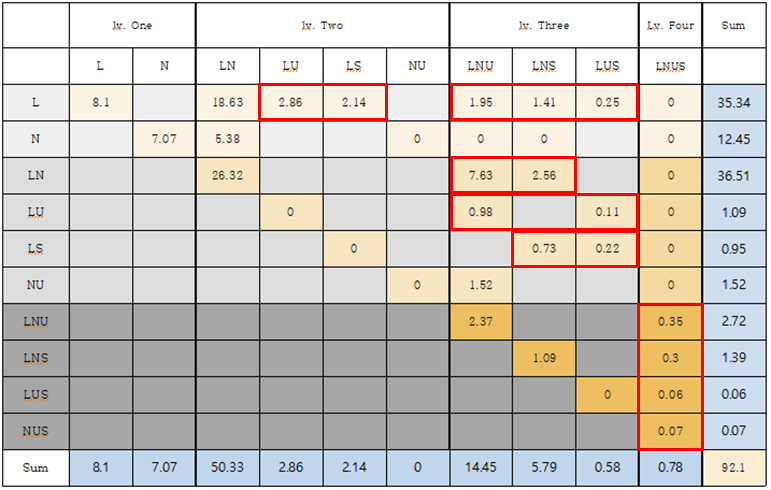

위에 확보된 1.4억 쌍의 데이터를
(src의 개수, tgt의 개수)로 표현하면 다음과 같이 다양하게 존재 한다. 

(1,3) - src 1개, tgt 3개
(1,5) - src 1개, tgt 5개
(3,1) - src 3개, tgt 1개 (armagedonq, armagedonqw, armagedon) -> (Armagedon5)
(3,2) - src 3개, tgt 2개

3번째 예시는 다음 과 같이  3 * 1 = 3개의 형태로 src, tgt을 다시 쓸 수 있다. 
(armagedonq) -> (Armagedon5)
(armagedonqw) -> (Armagedon5)
(armagedon) -> (Armagedon5)

이렇게 다시 src, tgt 데이터를 다시정리한다면
최초 1.4억 개의 src,tgt쌍(n개, n개)은 총 3.34억 개(334,776,661)의 쌍(1개, 1개)로 다시 정리한다. 
